# Gene-Level Curve Fitting and Feature Correlation Analysis

## Overview

This notebook performs comprehensive correlation analysis between **curve fitting parameters** extracted from time-resolved fitness data and **genomic/proteomic features** of S. pombe genes.

### Background
- **Curve fitting**: Gompertz function was used to model time-resolved fitness data, extracting three key parameters:
  - **A**: Asymptotic fitness level (final growth capacity)
  - **um**: Maximum growth rate 
  - **lam**: Lag phase duration (time to reach maximum growth rate)

### Objectives
1. Load and explore curve fitting results and gene feature datasets
2. Perform correlation analysis between curve parameters and gene features
3. Create comprehensive scatter plots to visualize relationships
4. Identify significant biological patterns and associations
5. Summarize key findings with statistical significance

### Data Sources
- **Curve fitting data**: `Gene_level_statistics_fitted.csv` - Contains A, um, lam parameters from Gompertz fitting
- **Gene features**: `collected_pombe_gene_features.csv` - Contains comprehensive gene annotations and molecular properties


In [1]:
"""
Gene-level clustering analysis setup and imports.
"""

# Standard library imports
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns


# Machine learning
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Visualization
from cycler import cycler
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ All imports successful")
logger.info("Setup complete")


2025-08-01 00:01:44,251 - INFO - Setup complete


✓ All imports successful


## ⚙️ Professional Styling Configuration

Set up consistent, publication-ready styling for all plots.

In [2]:
# Professional styling configuration
def setup_plot_style():
    """Configure matplotlib with professional, publication-ready defaults."""
    
    # General appearance
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white',
        'savefig.dpi': 300,
        'figure.dpi': 100,
        
        # Typography
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 10,
        'axes.titlesize': 16,
        'axes.titleweight': 'bold',
        'axes.labelsize': 14,
        'axes.labelweight': 'semibold',
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        
        # Line and marker properties
        'axes.linewidth': 2.0,
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'patch.linewidth': 2.0,
        
        # Spine and tick properties
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.bottom': True,
        'xtick.top': False,
        'ytick.left': True,
        'ytick.right': False,
        
        # Grid properties
        'axes.grid': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'axes.axisbelow': True,
        
        # Legend properties
        'legend.frameon': True,
        'legend.numpoints': 1,
    })

def clean_axes(ax):
    """Apply clean styling to axes - removes top and right spines."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.grid(True, alpha=0.3, linewidth=0.8)
    return ax

def add_stats_annotation(ax, text, x=0.05, y=0.95):
    """Add statistical annotation to plot."""
    ax.text(x, y, text, transform=ax.transAxes, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
           verticalalignment='top', fontsize=9)

def save_plot(fig, filename, formats=['png', 'svg'], dpi=300):
    """Save plot in multiple formats with consistent settings."""
    for fmt in formats:
        filepath = Path(f"{filename}.{fmt}")
        fig.savefig(filepath, format=fmt, dpi=dpi, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    print(f"Plot saved as: {', '.join([f'{filename}.{fmt}' for fmt in formats])}")

# Apply the styling
setup_plot_style()
print("Professional styling configuration applied!")

# Standard figure sizes for different use cases
FIGURE_SIZES = {
    'small': (4, 3),      # Single plots, supplements
    'medium': (6, 4.5),   # Standard journal figures  
    'large': (8, 6),      # Complex plots with multiple elements
    'wide': (10, 4),      # Time series, genomic data
    'square': (4, 4),     # Correlation plots, heatmaps
}

FIGURE_DPI = 300

print("Available figure sizes:", list(FIGURE_SIZES.keys()))


Professional styling configuration applied!
Available figure sizes: ['small', 'medium', 'large', 'wide', 'square']


## 🎨 Custom Color Palette

Professional color palette organized by hue families for better visual harmony and accessibility.


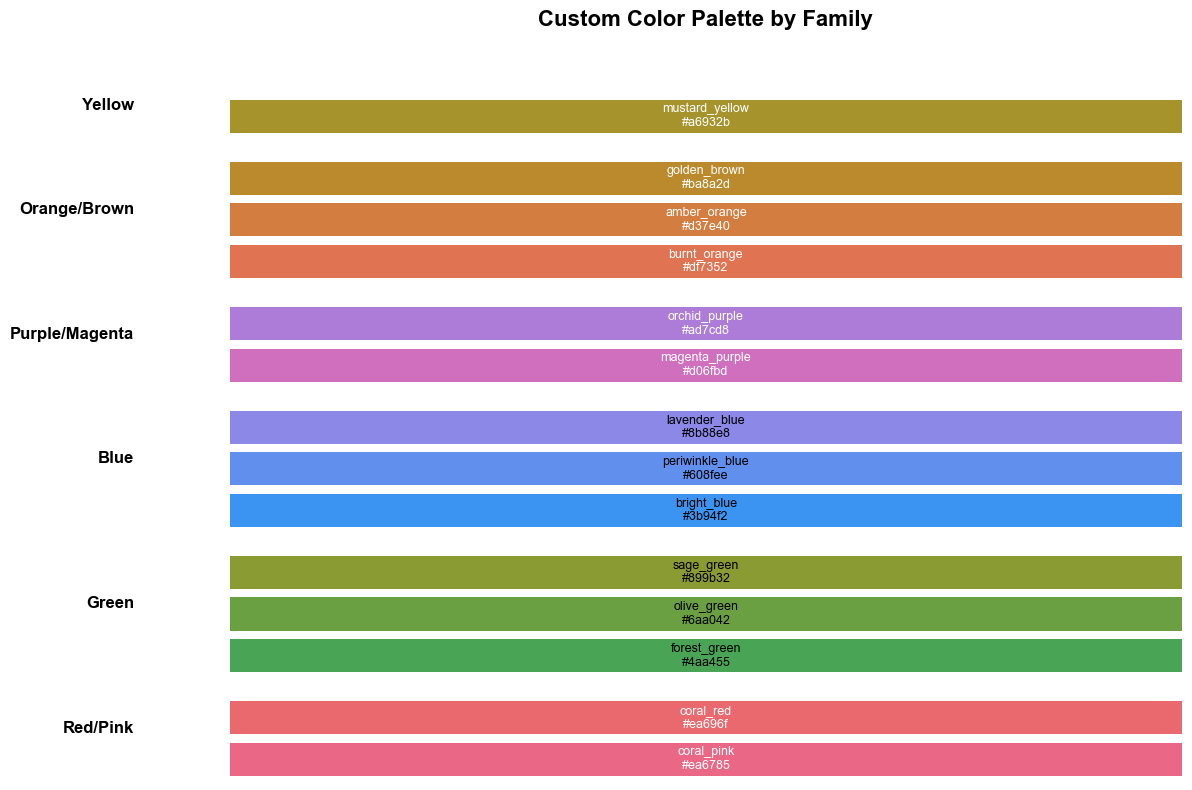

Color palette loaded successfully!
Primary trio: ['#ea696f', '#6aa042', '#608fee']
Four-category palette: ['#ea696f', '#6aa042', '#608fee', '#ad7cd8']


In [3]:
# Custom Color Palette - Organized by families
COLORS = {
    'coral_pink': '#ea6785',
    'forest_green': '#4aa455',
    'bright_blue': '#3b94f2',
    'magenta_purple': '#d06fbd',
    'golden_brown': '#ba8a2d',
    'coral_red': '#ea696f',
    'olive_green': '#6aa042',
    'periwinkle_blue': '#608fee',
    'burnt_orange': '#df7352',
    'sage_green': '#899b32',
    'lavender_blue': '#8b88e8',
    'amber_orange': '#d37e40',
    'mustard_yellow': '#a6932b',
    'orchid_purple': '#ad7cd8'
}

# Recommended color combinations
PRIMARY_TRIO = [COLORS['coral_red'], COLORS['olive_green'], COLORS['periwinkle_blue']]
FOUR_CATEGORY = PRIMARY_TRIO + [COLORS['orchid_purple']]
SIX_CATEGORY = FOUR_CATEGORY + [COLORS['magenta_purple'], COLORS['golden_brown']]

# Set as default matplotlib color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=PRIMARY_TRIO)

# Display color palette
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
families = {
    'Red/Pink': ['coral_pink', 'coral_red'],
    'Green': ['forest_green', 'olive_green', 'sage_green'],
    'Blue': ['bright_blue', 'periwinkle_blue', 'lavender_blue'],
    'Purple/Magenta': ['magenta_purple', 'orchid_purple'],
    'Orange/Brown': ['burnt_orange', 'amber_orange', 'golden_brown'],
    'Yellow': ['mustard_yellow']
}

y_pos = 0
for family_name, color_names in families.items():
    for i, color_name in enumerate(color_names):
        ax.barh(y_pos, 1, color=COLORS[color_name], height=0.8)
        ax.text(0.5, y_pos, f'{color_name}\n{COLORS[color_name]}', 
               ha='center', va='center', fontsize=9, 
               color='white' if color_name in ['coral_pink', 'coral_red', 'magenta_purple', 'orchid_purple', 'burnt_orange', 'amber_orange', 'golden_brown', 'mustard_yellow'] else 'black')
        y_pos += 1
    y_pos += 0.5  # Add space between families
    
    # Add family label
    ax.text(-0.1, y_pos - len(color_names)/2 - 0.75, family_name, 
           ha='right', va='center', fontsize=12, weight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, y_pos)
ax.set_title('Custom Color Palette by Family', fontsize=16, weight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

print("Color palette loaded successfully!")
print(f"Primary trio: {PRIMARY_TRIO}")
print(f"Four-category palette: {FOUR_CATEGORY}")

def create_gradient_colormap(base_color, name='custom_gradient'):
    """
    Create a gradient colormap from white to a given base color.
    
    Args:
        base_color: Base color (can be hex string, RGB tuple, or named color)
        name: Name for the colormap
        
    Returns:
        matplotlib.colors.LinearSegmentedColormap
    """
    # Convert base color to RGB if needed
    if isinstance(base_color, str):
        base_rgb = mcolors.to_rgb(base_color)
    else:
        base_rgb = base_color
    
    # Create gradient from 0.4 transparent base color to base color
    light_base = tuple(0.9 + 0.1*c for c in base_rgb)  # 10% base color, 90% white
    colors = [light_base, base_rgb]
    n_bins = 10
    cmap = mcolors.LinearSegmentedColormap.from_list(name, colors, N=n_bins)
    return cmap


## Data Loading and Initial Exploration

We'll start by loading both datasets and examining their structure and content to understand what features are available for correlation analysis.


2025-08-01 00:08:24,382 - INFO - Loading curve fitting data from: ../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results_kmeans64mergedto7.tsv
2025-08-01 00:08:24,401 - INFO - Loading gene features data from: ../../resources/pombase_data/collected_pombe_gene_features.csv
2025-08-01 00:08:24,435 - INFO - Curve data shape: (4519, 33)
2025-08-01 00:08:24,436 - INFO - Gene features shape: (5134, 42)


=== CURVE FITTING DATA ===
Shape: (4519, 33)
Columns: ['Name', 'FYPOviability', 'RevisedDeletion_essentiality', 'DeletionLibrary_essentiality', 'time_points', 'Status', 'A', 'um', 'lam', 'R2', 'RMSE', 'normalized_RMSE', 't0', 't1', 't2', 't3', 't4', 't0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted', 't0_residual', 't1_residual', 't2_residual', 't3_residual', 't4_residual', 'cluster_kmeans_um_lam', 'cluster_hierarchical_agg_um_lam', 'cluster_hierarchical_div_um_lam', 'cluster_gmm_um_lam', 'previous_manual_clustering', 'revised_cluster']

First few rows:
                   A     um   lam     R2   RMSE   Status
Systematic ID                                           
SPAC1002.02    0.177 -0.021  0.00 -0.462  0.136  Success
SPAC1002.03c   0.253  0.025  0.00  0.253  0.127  Success
SPAC1002.04c   8.686  0.730  2.65  0.997  0.142  Success
SPAC1002.05c   0.116 -0.010  0.00 -0.747  0.104  Success
SPAC1002.06c  -0.134 -0.023 -0.00  0.207  0.052  Success

=== GENE FEATURES DATA ===


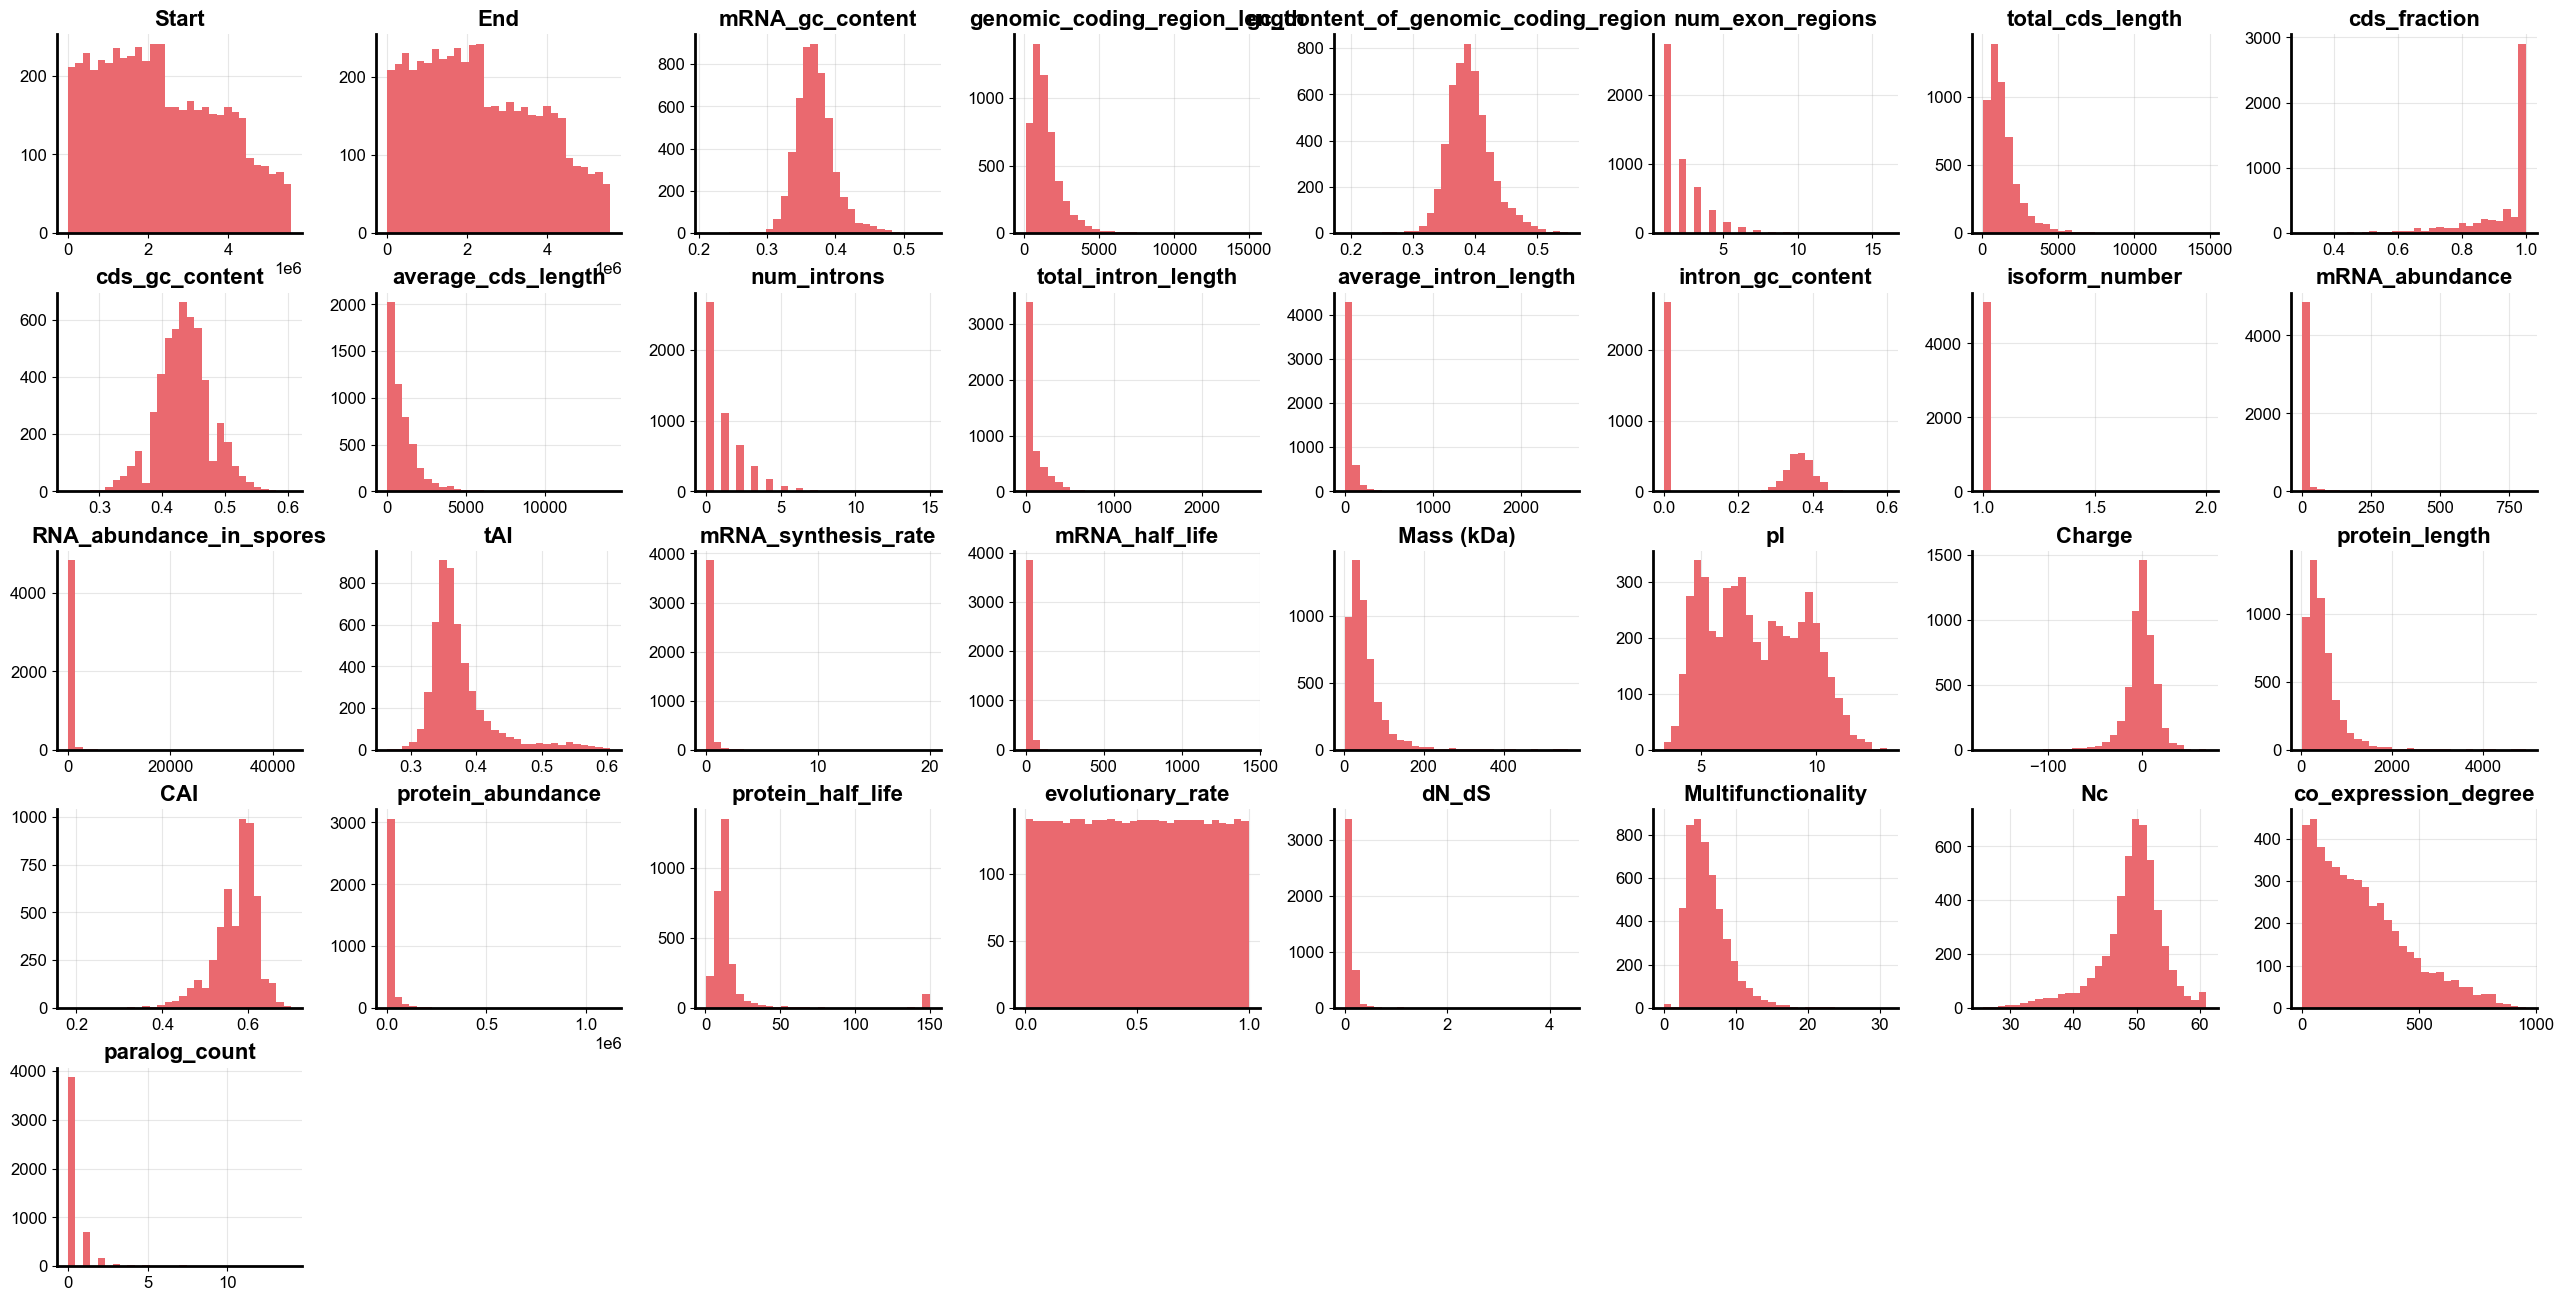

In [13]:
def load_and_explore_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load curve fitting results and gene features data.
    
    Returns:
        Tuple of (curve_data, gene_features) DataFrames
    """
    # Define file paths
    input_data_path = Path("../../results/HD_DIT_HAP/20_gene_level_clustering/gene_level_clustering_results_kmeans64mergedto7.tsv")
    gene_features_path = Path("../../resources/pombase_data/collected_pombe_gene_features.csv")
    
    # Load curve fitting data
    logging.info(f"Loading curve fitting data from: {input_data_path}")
    curve_data = pd.read_csv(input_data_path, sep="\t")
    curve_data.set_index('Systematic ID', inplace=True)
    
    # Load gene features data
    logging.info(f"Loading gene features data from: {gene_features_path}")
    gene_features = pd.read_csv(gene_features_path)
    gene_features.set_index('Systematic_ID', inplace=True)
    
    logging.info(f"Curve data shape: {curve_data.shape}")
    logging.info(f"Gene features shape: {gene_features.shape}")
    
    return curve_data, gene_features

# Load the data
curve_data, gene_features = load_and_explore_data()

print("=== CURVE FITTING DATA ===")
print(f"Shape: {curve_data.shape}")
print(f"Columns: {list(curve_data.columns)}")
print("\nFirst few rows:")
print(curve_data[['A', 'um', 'lam', 'R2', 'RMSE', 'Status']].head())

print("\n=== GENE FEATURES DATA ===")
print(f"Shape: {gene_features.shape}")
print(f"Columns: {list(gene_features.columns)}")
print("\nFirst few rows:")
print(gene_features[['Gene_name', 'FYPOviability', 'protein_length', 'mRNA_abundance']].head())
# histogram

gene_features.hist(bins=30, figsize=(32, 16), layout=(5, 8))
plt.show()
plt.close()


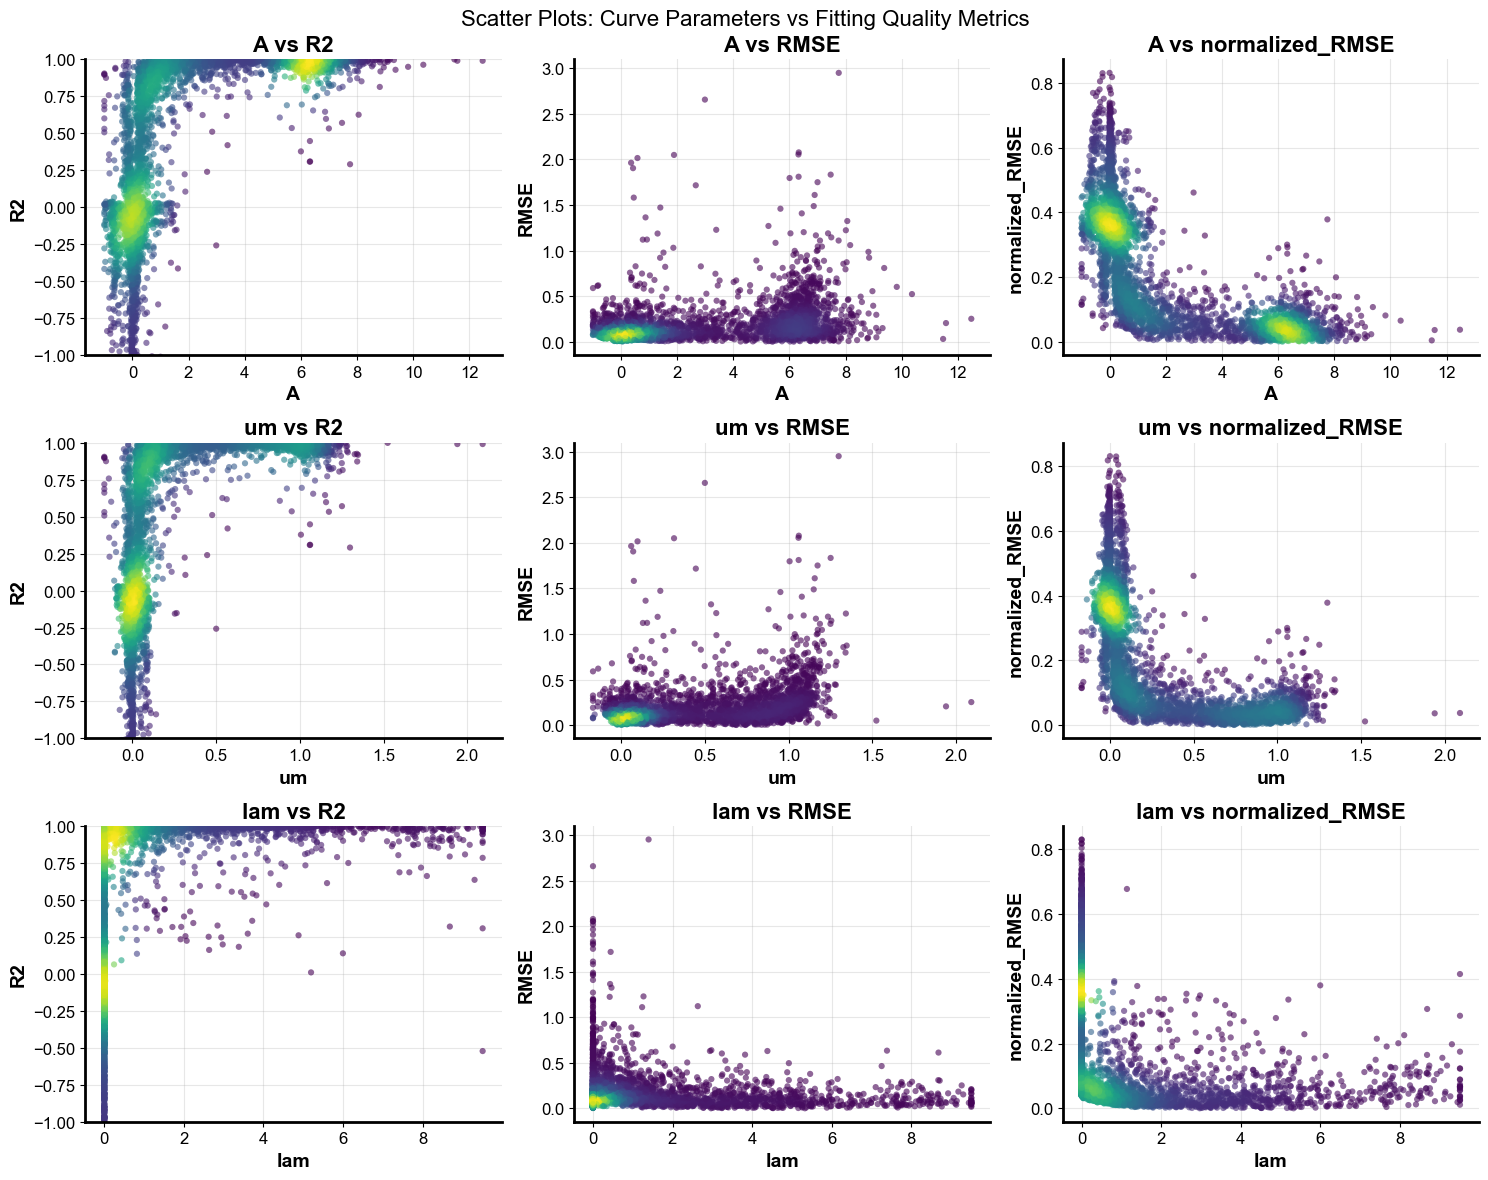

In [14]:
# Create scatter plots between curve fitting parameters
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Scatter Plots: Curve Parameters vs Fitting Quality Metrics', fontsize=16)

# Define X and Y variables
x_vars = ['A', 'um', 'lam']
y_vars = ['R2', 'RMSE', 'normalized_RMSE']

# Create scatter plots
for i, x_var in enumerate(x_vars):
    for j, y_var in enumerate(y_vars):
        ax = axes[i, j]
        
        # Filter out any missing values
        mask = ~(curve_data[x_var].isna() | curve_data[y_var].isna())
        x_data = curve_data.loc[mask, x_var]
        y_data = curve_data.loc[mask, y_var]

        x_data, y_data = x_data[x_data.notna() & y_data.notna()], y_data[x_data.notna() & y_data.notna()]
        
        xy = np.vstack([x_data, y_data])
        z = stats.gaussian_kde(xy)(xy)
        
        # Create scatter plot
        ax.scatter(x_data, y_data, alpha=0.6, s=20, c=z, cmap='viridis', edgecolors='none')
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
        ax.set_title(f'{x_var} vs {y_var}')
        ax.grid(True, alpha=0.3)
        if y_var == 'R2':
            ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()
plt.close()


In [7]:
def safe_log_transform(data, feature, method='log10'):
    """Safely apply log transformation"""
    
    # Handle zeros and negatives
    if (data[feature] <= 0).any():
        # Add small constant (pseudo-count)
        min_positive = data[data[feature] > 0][feature].min()
        pseudo_count = min_positive / 10
        transformed = np.log10(data[feature] + pseudo_count)
    else:
        transformed = np.log10(data[feature])
    
    return transformed

def prepare_correlation_data(curve_data: pd.DataFrame, gene_features: pd.DataFrame, log_transform: dict[str, bool]) -> pd.DataFrame:
    """
    Merge curve fitting and gene features data, preparing for correlation analysis.
    
    Args:
        curve_data: DataFrame with curve fitting parameters
        gene_features: DataFrame with gene features
        
    Returns:
        Merged DataFrame ready for correlation analysis
    """
    # Define curve features of interest
    curve_features = ['A', 'um', 'lam', 'R2', 'RMSE', 'normalized_RMSE']
    
    # Select numeric gene features for correlation analysis
    numeric_features = gene_features.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove features with too many missing values (>50%)
    # valid_features = []
    # for col in numeric_features:
    #     missing_pct = gene_features[col].isna().sum() / len(gene_features)
    #     if missing_pct < 0.5:  # Keep features with <50% missing values
    #         valid_features.append(col)
    
    # logging.info(f"Selected {len(valid_features)} numeric gene features with <50% missing values")

    valid_features = numeric_features
    
    # make a new dataframe with the valid features for proper transformation
    valid_features_df = gene_features[valid_features].copy()

    for feature in valid_features:
        if feature in log_transform and log_transform[feature]:
            valid_features_df[feature] = safe_log_transform(valid_features_df, feature)

    # Merge datasets on Systematic ID
    merged_data = curve_data[curve_features].merge(
        valid_features_df, 
        left_index=True, 
        right_index=True, 
        how='inner'
    )
    
    # Filter for successful curve fits only
    merged_data = merged_data[curve_data['Status'] == 'Success'].copy()
    
    logging.info(f"Merged dataset shape: {merged_data.shape}")
    logging.info(f"Genes with successful curve fits: {len(merged_data)}")
    
    return merged_data, curve_features, valid_features_df.columns.tolist()

log_transform = {
    'mRNA_abundance': True,
    'tAI': False,
    'mRNA_synthesis_rate': True,
    'mRNA_half_life': True,
    'Mass (kDa)': True,
    'pI': False,
    'Charge': False,
    'protein_length': True,
    'CAI': False,
    'protein_abundance': True,
    'evolutionary_rate': False,
    'dN_dS': True,
    'Multifunctionality': False,
    'Nc': False,
    'co_expression_degree': False,
    'paralog_count': False
}

# Prepare data for correlation analysis
merged_data, curve_features, gene_feature_list = prepare_correlation_data(curve_data, gene_features, log_transform)

curve_features = ['A', 'um', 'lam']


gene_feature_list = [
    'mRNA_abundance',
    'tAI',
    'mRNA_synthesis_rate',
    'mRNA_half_life',
    'Mass (kDa)',
    'pI',
    'Charge',
    'protein_length',
    'CAI',
    'protein_abundance',
    'evolutionary_rate',
    'dN_dS',
    'Multifunctionality',
    'Nc',
    'co_expression_degree',
    'paralog_count'
]


print(f"Final merged dataset shape: {merged_data.shape}")
print(f"Curve features: {curve_features}")
print(f"Number of gene features: {len(gene_feature_list)}")
print(f"Sample gene features: {gene_feature_list[:10]}")

# Display basic statistics
print("\n=== CURVE PARAMETER STATISTICS ===")
print(merged_data[curve_features].describe().round(4))


2025-08-01 00:04:55,038 - INFO - Merged dataset shape: (4519, 39)
2025-08-01 00:04:55,039 - INFO - Genes with successful curve fits: 4519


Final merged dataset shape: (4519, 39)
Curve features: ['A', 'um', 'lam']
Number of gene features: 16
Sample gene features: ['mRNA_abundance', 'tAI', 'mRNA_synthesis_rate', 'mRNA_half_life', 'Mass (kDa)', 'pI', 'Charge', 'protein_length', 'CAI', 'protein_abundance']

=== CURVE PARAMETER STATISTICS ===
               A         um        lam
count  4519.0000  4519.0000  4519.0000
mean      2.2618     0.3043     0.9604
std       2.8647     0.3989     1.8671
min      -1.0000    -0.1680    -0.0000
25%       0.0060     0.0020    -0.0000
50%       0.5670     0.0710     0.0000
75%       5.6835     0.6390     1.0175
max      12.4800     2.0910     9.5110


## Comprehensive Correlation Analysis

Now we'll compute correlations between each curve fitting parameter (A, um, lam) and all available gene features. We'll use both Pearson and Spearman correlations to capture linear and monotonic relationships.


In [9]:
def calculate_correlations(data: pd.DataFrame, curve_features: List[str], 
                          gene_features: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Calculate Pearson and Spearman correlations between curve and gene features.
    
    Args:
        data: Merged DataFrame with both curve and gene features
        curve_features: List of curve parameter names
        gene_features: List of gene feature names
        
    Returns:
        Dictionary containing correlation matrices and p-values
    """
    results = {}
    
    # Focus on main curve parameters for correlation analysis
    main_curve_features = ['A', 'um', 'lam']
    
    for curve_param in main_curve_features:
        pearson_corrs = []
        pearson_pvals = []
        spearman_corrs = []
        spearman_pvals = []
        valid_features = []
        
        for gene_feature in gene_features:
            # Remove rows where either value is NaN
            valid_data = data[[curve_param, gene_feature]].dropna()
            
            if len(valid_data) < 10:  # Skip if too few data points
                continue
                
            valid_features.append(gene_feature)
            
            # Calculate Pearson correlation
            pearson_r, pearson_p = stats.pearsonr(valid_data[curve_param], valid_data[gene_feature])
            pearson_corrs.append(pearson_r)
            pearson_pvals.append(pearson_p)
            
            # Calculate Spearman correlation
            spearman_r, spearman_p = stats.spearmanr(valid_data[curve_param], valid_data[gene_feature])
            spearman_corrs.append(spearman_r)
            spearman_pvals.append(spearman_p)
        
        # Create results DataFrame
        corr_df = pd.DataFrame({
            'gene_feature': valid_features,
            'pearson_r': pearson_corrs,
            'pearson_p': pearson_pvals,
            'spearman_r': spearman_corrs,
            'spearman_p': spearman_pvals,
            'n_samples': [len(data[[curve_param, feat]].dropna()) for feat in valid_features]
        })
        
        # Add significance indicators
        corr_df['pearson_sig'] = corr_df['pearson_p'] < 0.05
        corr_df['spearman_sig'] = corr_df['spearman_p'] < 0.05
        
        # Sort by absolute Pearson correlation
        corr_df['abs_pearson_r'] = np.abs(corr_df['pearson_r'])
        corr_df = corr_df.sort_values('abs_pearson_r', ascending=False)
        
        results[curve_param] = corr_df
        
        logging.info(f"Calculated correlations for {curve_param}: {len(corr_df)} valid gene features")
    
    return results

# Calculate correlations
correlation_results = calculate_correlations(merged_data, curve_features, gene_feature_list)

# Display top correlations for each parameter
for param in ['A', 'um', 'lam']:
    print(f"\n=== TOP 10 CORRELATIONS FOR {param.upper()} ===")
    top_corrs = correlation_results[param].head(10)
    display_cols = ['gene_feature', 'pearson_r', 'pearson_p', 'spearman_r', 'spearman_p', 'n_samples']
    print(top_corrs[display_cols].round(4))


2025-08-01 00:05:23,341 - INFO - Calculated correlations for A: 16 valid gene features
2025-08-01 00:05:23,425 - INFO - Calculated correlations for um: 16 valid gene features
2025-08-01 00:05:23,504 - INFO - Calculated correlations for lam: 16 valid gene features



=== TOP 10 CORRELATIONS FOR A ===
            gene_feature  pearson_r  pearson_p  spearman_r  spearman_p  \
10     evolutionary_rate    -0.2910        0.0     -0.2842         0.0   
11                 dN_dS    -0.2718        0.0     -0.2723         0.0   
0         mRNA_abundance     0.2590        0.0      0.2592         0.0   
2    mRNA_synthesis_rate     0.2374        0.0      0.2387         0.0   
3         mRNA_half_life     0.1896        0.0      0.1824         0.0   
14  co_expression_degree     0.1837        0.0      0.2046         0.0   
12    Multifunctionality     0.1691        0.0      0.2008         0.0   
13                    Nc    -0.1591        0.0     -0.1592         0.0   
15         paralog_count    -0.1551        0.0     -0.1740         0.0   
1                    tAI     0.1411        0.0      0.1284         0.0   

    n_samples  
10       3769  
11       3783  
0        4513  
2        3646  
3        3646  
14       4454  
12       4408  
13       4454  
15    

## Visualization: Correlation Heatmaps

Let's create heatmaps to visualize the correlation patterns between curve parameters and gene features. This will help identify clusters of related features and overall correlation strength.


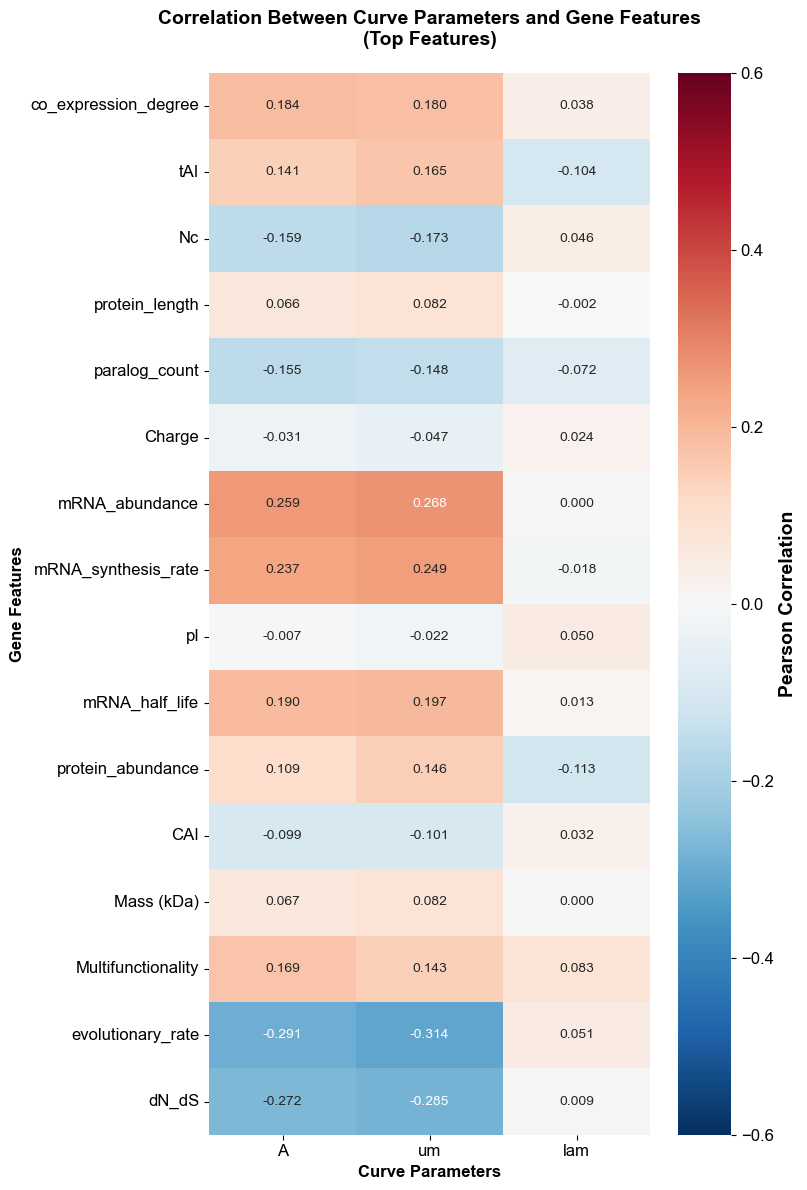

In [10]:
def create_correlation_heatmap(correlation_results: Dict[str, pd.DataFrame], 
                              top_n: int = 20) -> None:
    """
    Create heatmap showing correlations between curve parameters and top gene features.
    
    Args:
        correlation_results: Dictionary with correlation results for each curve parameter
        top_n: Number of top features to display for each parameter
    """
    # Collect top features for each parameter
    all_top_features = set()
    for param in ['A', 'um', 'lam']:
        top_features = correlation_results[param].head(top_n)['gene_feature'].tolist()
        all_top_features.update(top_features)
    
    all_top_features = list(all_top_features)
    
    # Create correlation matrix
    correlation_matrix = pd.DataFrame(index=all_top_features, columns=['A', 'um', 'lam'])
    
    for param in ['A', 'um', 'lam']:
        param_corrs = correlation_results[param].set_index('gene_feature')
        for feature in all_top_features:
            if feature in param_corrs.index:
                correlation_matrix.loc[feature, param] = param_corrs.loc[feature, 'pearson_r']
            else:
                correlation_matrix.loc[feature, param] = np.nan
    
    # Convert to numeric
    correlation_matrix = correlation_matrix.astype(float)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(8, 12))
    
    # Create mask for missing values
    mask = correlation_matrix.isna()
    
    # Plot heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                vmin=-0.6, 
                vmax=0.6,
                square=False,
                cbar_kws={'label': 'Pearson Correlation'},
                ax=ax)
    
    ax.set_title('Correlation Between Curve Parameters and Gene Features\n(Top Features)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Curve Parameters', fontsize=12, fontweight='bold')
    ax.set_ylabel('Gene Features', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Create correlation heatmap
create_correlation_heatmap(correlation_results, top_n=15)


## Detailed Scatter Plot Analysis

Now we'll create detailed scatter plots for the most significant correlations. This will allow us to visualize the actual relationships and identify any outliers or non-linear patterns.


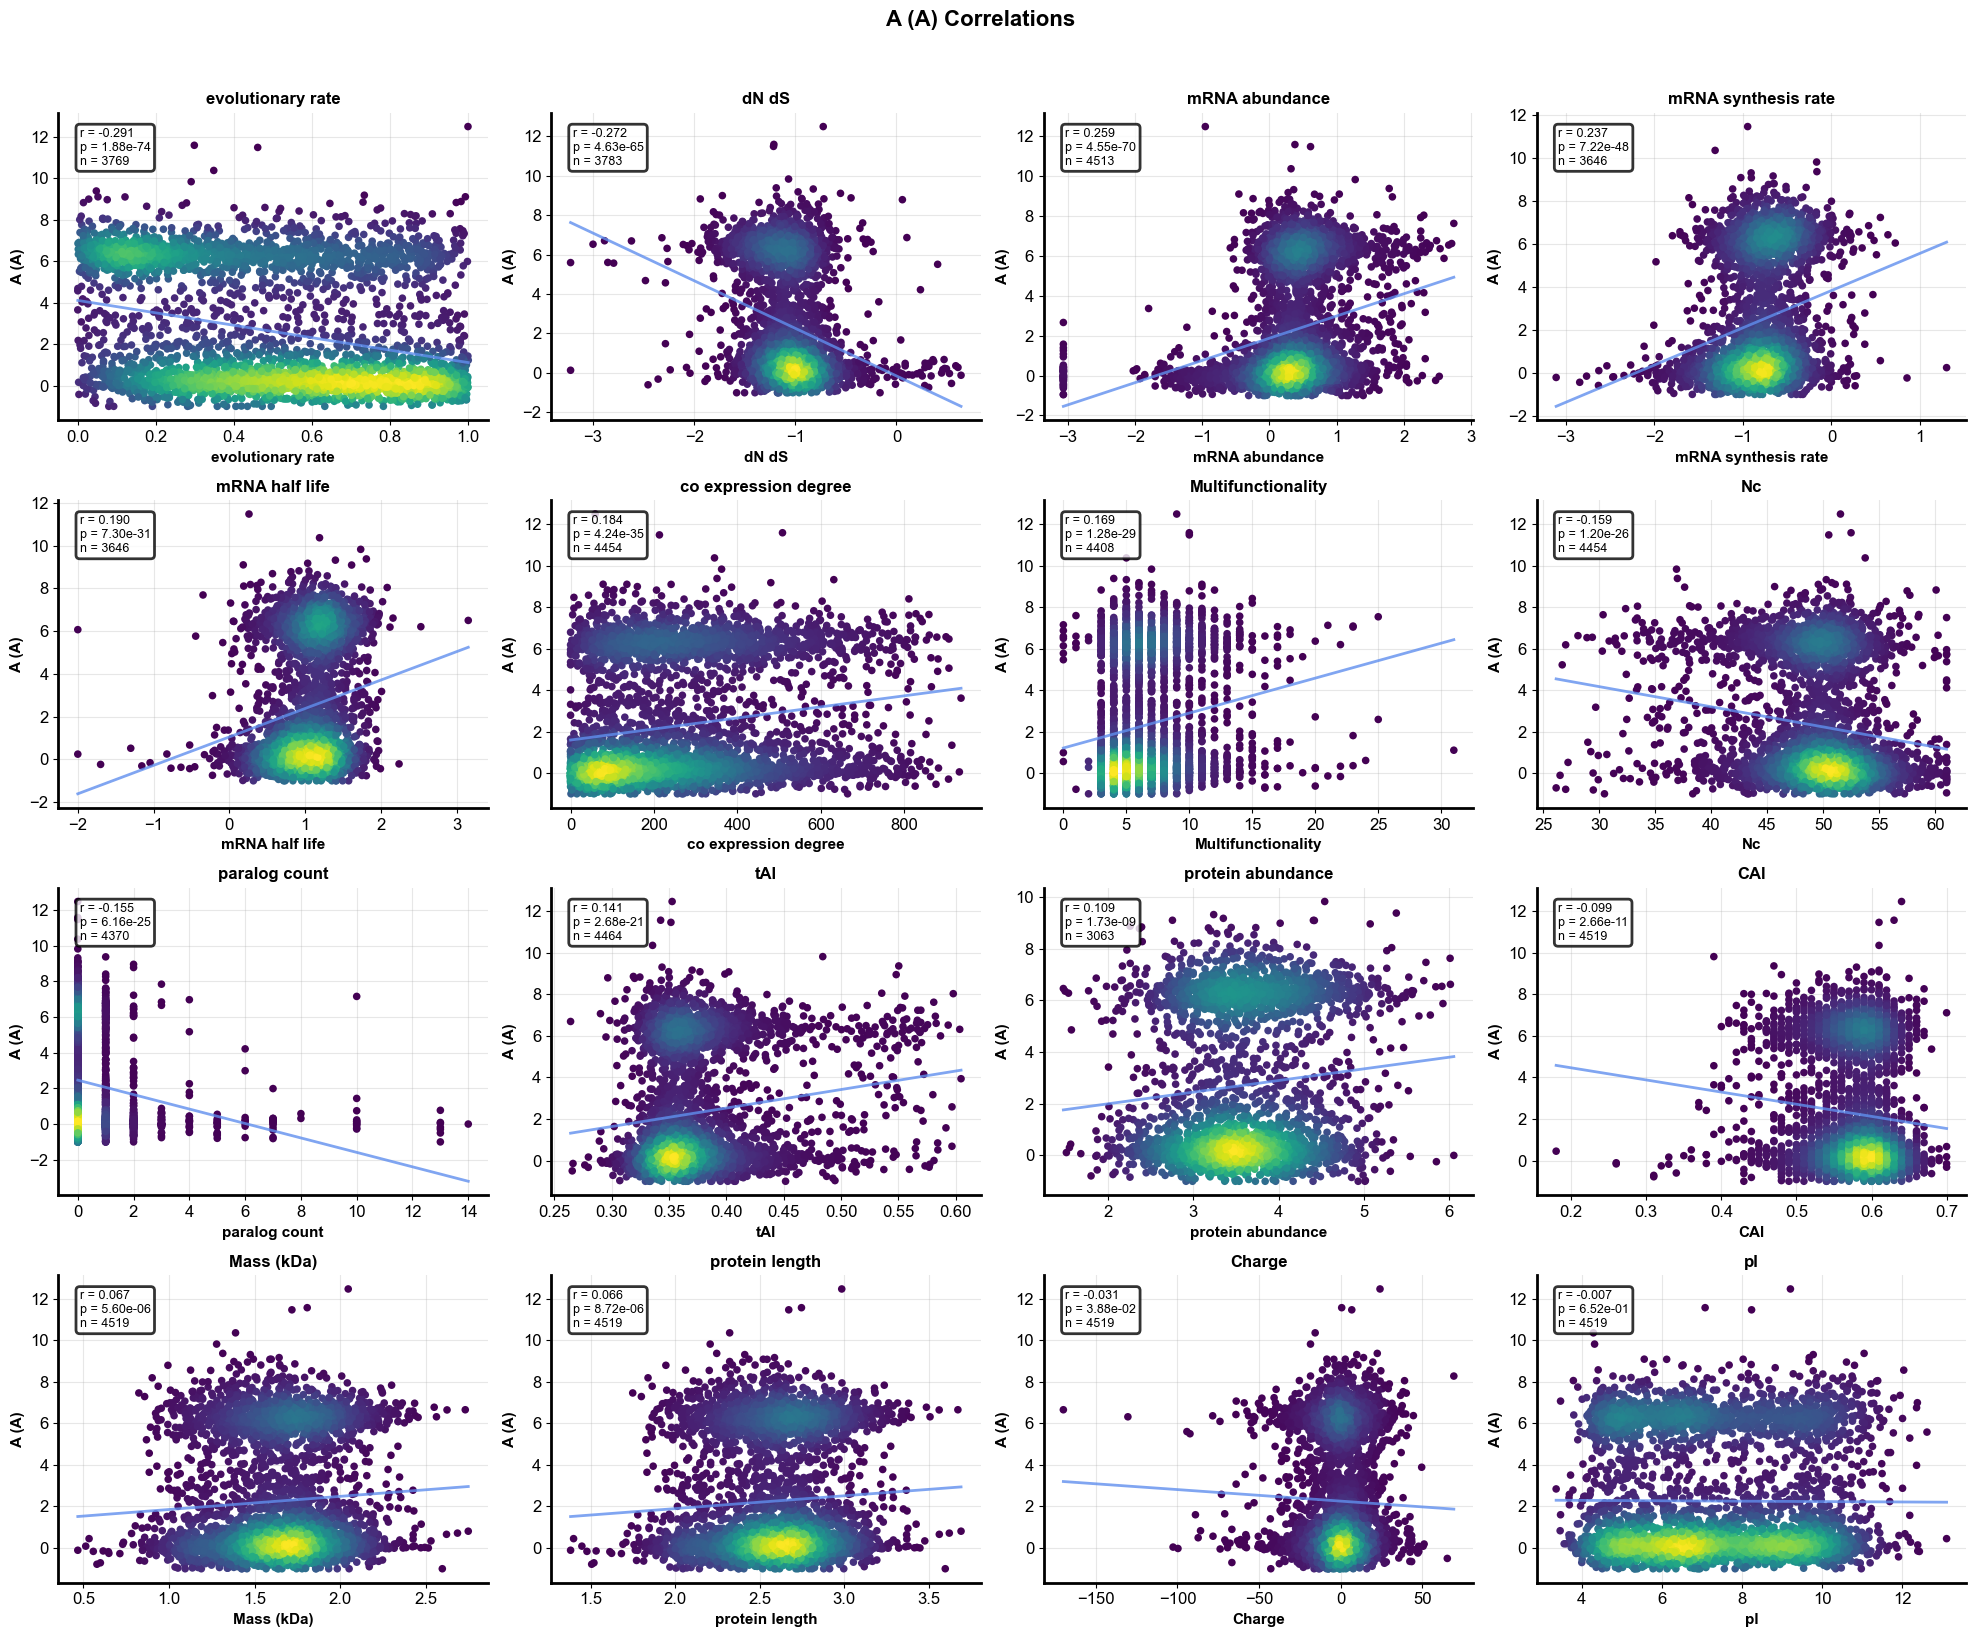

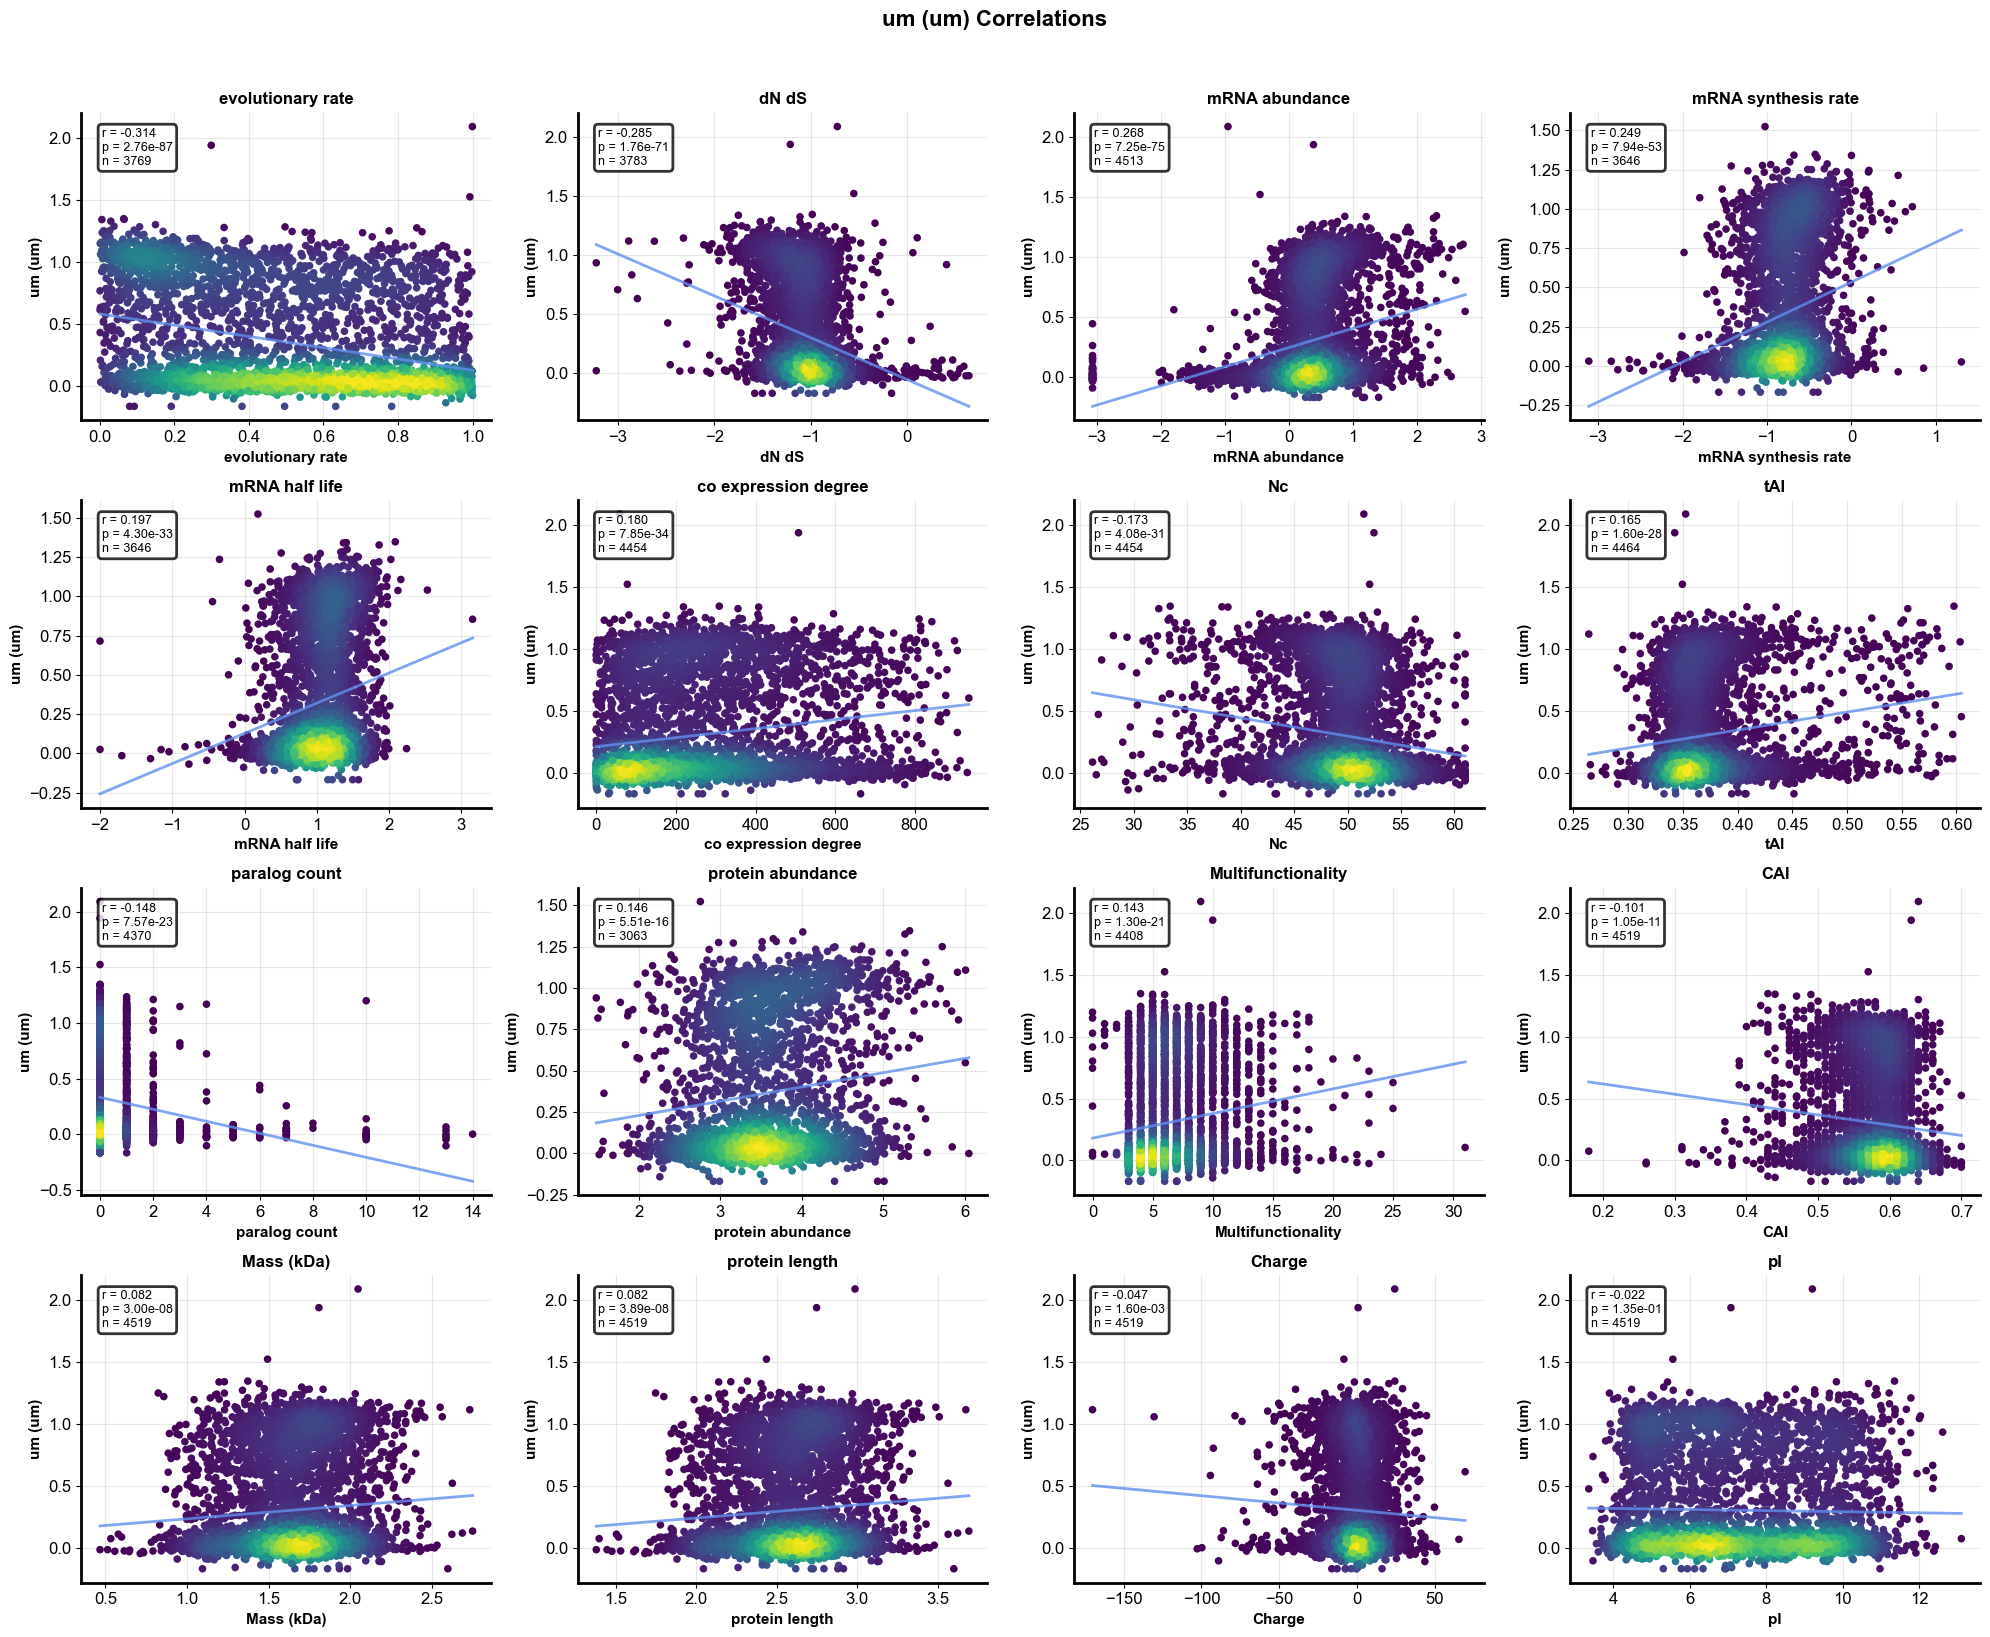

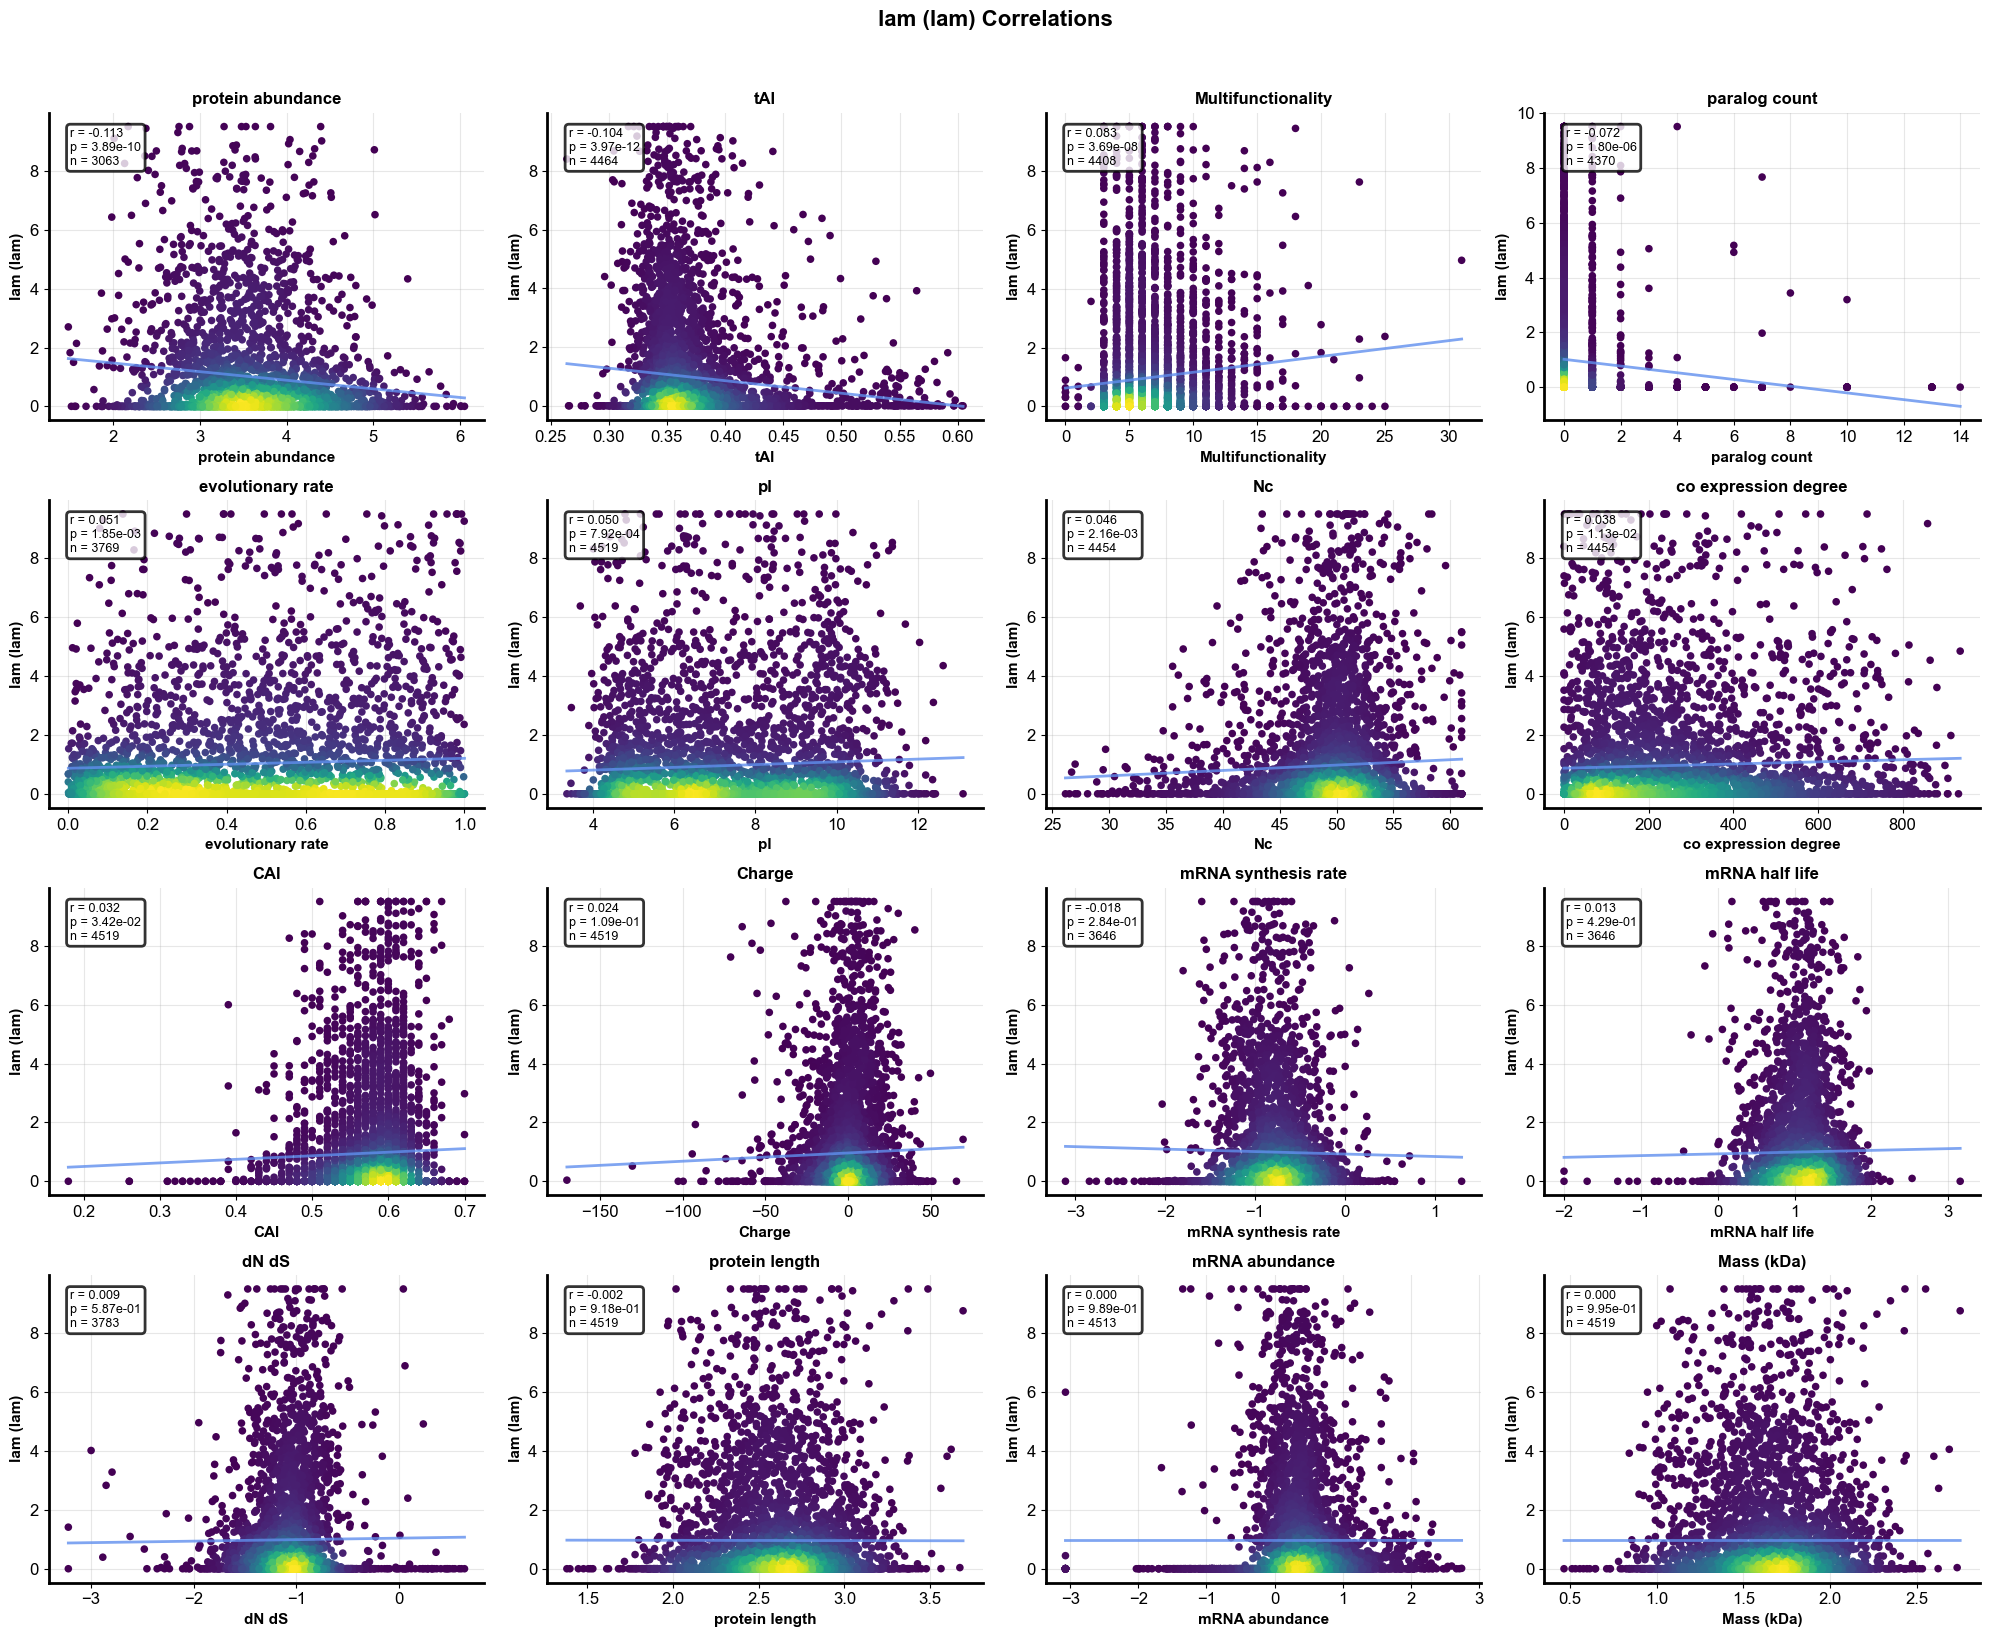

In [12]:
def create_scatter_plots(data: pd.DataFrame, correlation_results: Dict[str, pd.DataFrame], 
                        n_plots: int = 3) -> None:
    """
    Create scatter plots for the top correlations of each curve parameter.
    
    Args:
        data: Merged DataFrame with curve and gene features
        correlation_results: Dictionary with correlation results
        n_plots: Number of top correlations to plot for each parameter
    """
    curve_params = ['A', 'um', 'lam']
    param_descriptions = {
        'A': 'A',
        'um': 'um', 
        'lam': 'lam'
    }
    
    for i, param in enumerate(curve_params):
        # Get top correlations
        top_corrs = correlation_results[param].head(n_plots)

        n_cols = 4
        n_rows = n_plots//n_cols + (1 if n_plots%n_cols > 0 else 0)
        
        # Create subplot
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        fig.suptitle(f'{param_descriptions[param]} ({param}) Correlations', 
                     fontsize=16, fontweight='bold', y=1.02)
        
        for j, (_, row) in enumerate(top_corrs.iterrows()):
            gene_feature = row['gene_feature']
            pearson_r = row['pearson_r']
            pearson_p = row['pearson_p']
            n_samples = row['n_samples']
            
            # Get clean data for plotting
            plot_data = data[[param, gene_feature]].dropna()
            
            # Create scatter plot
            ax = axes[j]

            x = plot_data[gene_feature]
            y = plot_data[param]
            xy = np.vstack([x, y])
            z = stats.gaussian_kde(xy)(xy)
            ax.scatter(x, y, c=z, s=30, edgecolors="none")
            
            # Add trend line
            if len(plot_data) > 1:
                z = np.polyfit(plot_data[gene_feature], plot_data[param], 1)
                p = np.poly1d(z)
                x_trend = np.linspace(plot_data[gene_feature].min(), 
                                    plot_data[gene_feature].max(), 100)
                ax.plot(x_trend, p(x_trend), color=COLORS["periwinkle_blue"], 
                       linewidth=2, alpha=0.8)
            
            # Format axes
            ax.set_xlabel(gene_feature.replace('_', ' '), fontsize=11)
            ax.set_ylabel(f'{param} ({param_descriptions[param]})', fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.set_title(f'{gene_feature.replace("_", " ")}', fontsize=12)
            
            # Add correlation statistics
            stats_text = f'r = {pearson_r:.3f}\np = {pearson_p:.2e}\nn = {n_samples}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        plt.close()

# Create scatter plots for top 3 correlations of each parameter
create_scatter_plots(merged_data, correlation_results, n_plots=len(gene_feature_list))


## Biological Context Analysis

Let's examine correlations in the context of gene essentiality and functional categories to understand the biological significance of our findings.


In [ ]:
def analyze_by_essentiality(data: pd.DataFrame, gene_features: pd.DataFrame) -> None:
    """
    Analyze curve parameters by gene essentiality groups.
    
    Args:
        data: Merged DataFrame with curve parameters
        gene_features: Original gene features DataFrame
    """
    # Merge with essentiality information
    essentiality_data = data.merge(
        gene_features[['FYPOviability']], 
        left_index=True, right_index=True, how='left'
    )
    
    # Create essentiality groups
    essential_genes = essentiality_data[essentiality_data['FYPOviability'] == 'inviable']
    viable_genes = essentiality_data[essentiality_data['FYPOviability'] == 'viable']
    
    print(f"Essential genes: {len(essential_genes)}")
    print(f"Viable genes: {len(viable_genes)}")
    
    # Compare distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    curve_params = ['A', 'um', 'lam']
    param_descriptions = {
        'A': 'Asymptotic Fitness Level',
        'um': 'Maximum Growth Rate', 
        'lam': 'Lag Phase Duration'
    }
    
    for i, param in enumerate(curve_params):
        ax = axes[i]
        
        # Create box plots
        data_to_plot = [
            essential_genes[param].dropna(),
            viable_genes[param].dropna()
        ]
        
        box_parts = ax.boxplot(data_to_plot, labels=['Essential', 'Viable'], 
                              patch_artist=True, notch=True)
        
        # Color the boxes
        box_parts['boxes'][0].set_facecolor(colors['primary'][0])  # Essential: Purple
        box_parts['boxes'][1].set_facecolor(colors['primary'][1])  # Viable: Green
        
        ax.set_title(f'{param_descriptions[param]} ({param})', fontweight='bold')
        ax.set_ylabel(param)
        ax.grid(True, alpha=0.3)
        
        # Add statistical test
        from scipy.stats import mannwhitneyu
        if len(data_to_plot[0]) > 0 and len(data_to_plot[1]) > 0:
            stat, p_val = mannwhitneyu(data_to_plot[0], data_to_plot[1], alternative='two-sided')
            ax.text(0.5, 0.95, f'Mann-Whitney U p = {p_val:.2e}', 
                   transform=ax.transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.suptitle('Curve Parameters by Gene Essentiality', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Analyze by essentiality
analyze_by_essentiality(merged_data, gene_features)
